In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-04-22 10:50:10.128042: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 10:50:10.182285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 10:50:10.182345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 10:50:10.187457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 10:50:10.204539: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 10:50:10.205659: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)

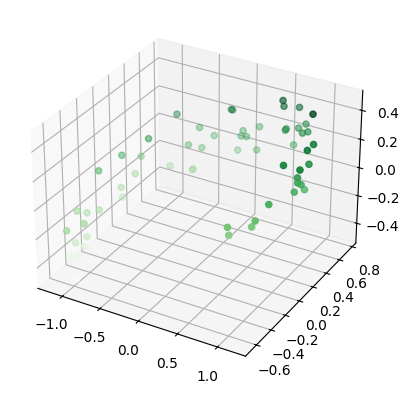

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2], cmap='Greens')

In [4]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape=[3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

autoencoder.fit(X_train, X_train, epochs=30)

2024-04-14 10:27:35.757427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 10:27:35.926905: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
2/2 [==============================] - 0s 5ms/step - loss: 0.7911
Epoch 2/30
2/2 [==============================] - 0s 3ms/step - loss: 0.7715
Epoch 3/30
2/2 [==============================] - 0s 3ms/step - loss: 0.7530
Epoch 4/30
2/2 [==============================] - 0s 3ms/step - loss: 0.7356
Epoch 5/30
2/2 [==============================] - 0s 2ms/step - loss: 0.7192
Epoch 6/30
2/2 [==============================] - 0s 2ms/step - loss: 0.7039
Epoch 7/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6897
Epoch 8/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6763
Epoch 9/30
2/2 [==============================] - 0s 2ms/step - loss: 0.6633
Epoch 10/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6514
Epoch 11/30
2/2 [==============================] - 0s 2ms/step - loss: 0.6400
Epoch 12/30
2/2 [==============================] - 0s 3ms/step - loss: 0.6296
Epoch 13/30
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


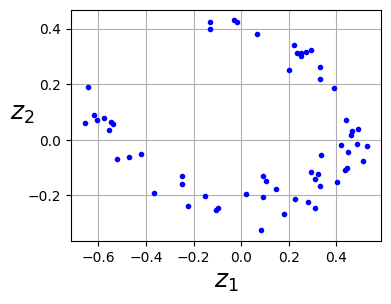

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255
X_train.shape

(48000, 28, 28)

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='selu')])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(784, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=30, validation_data=(X_val, X_val))

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3417 - rounded_accuracy: 0.8842 - val_loss: 0.3125 - val_rounded_accuracy: 0.9060
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3069 - rounded_accuracy: 0.9141 - val_loss: 0.3044 - val_rounded_accuracy: 0.9141
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3007 - rounded_accuracy: 0.9195 - val_loss: 0.2979 - val_rounded_accuracy: 0.9212
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2967 - rounded_accuracy: 0.9232 - val_loss: 0.2943 - val_rounded_accuracy: 0.9270
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2938 - rounded_accuracy: 0.9259 - val_loss: 0.2924 - val_rounded_accuracy: 0.9259
Epoch 6/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9276 - val_loss: 0.2933 - val_rounded_accuracy: 0.9230
Epoch 7/30
1500/1500 [==================

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
def show_reconstructions(model, images=X_val, n_images=5):
    true_images = images[:n_images]
    recon_images = model.predict(true_images)

    figure = plt.figure(figsize=(8.6, 6))
    for i in range(n_images):
        figure.add_subplot(2, n_images, i + 1)
        plot_image(true_images[i])
        figure.add_subplot(2, n_images, i + 1 + n_images)
        plot_image(recon_images[i])

In [13]:
# show_reconstructions(stacked_ae)

In [14]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

375/375 [==============================] - 0s 897us/step


In [15]:
plt.scatter(X_val_2D[:,0], X_val_2D[:, 1], c=y_val, s=10, cmap='tab10')

### Tying Weights

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', shape=[self.dense.input_shape[-1]], initializer="zeros")        
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
        

In [17]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3301 - rounded_accuracy: 0.8929 - val_loss: 0.3019 - val_rounded_accuracy: 0.9197
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2984 - rounded_accuracy: 0.9216 - val_loss: 0.2953 - val_rounded_accuracy: 0.9282
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2921 - rounded_accuracy: 0.9276 - val_loss: 0.2892 - val_rounded_accuracy: 0.9312
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2887 - rounded_accuracy: 0.9307 - val_loss: 0.2872 - val_rounded_accuracy: 0.9336
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2867 - rounded_accuracy: 0.9325 - val_loss: 0.2851 - val_rounded_accuracy: 0.9356
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2852 - rounded_accuracy: 0.9337 - val_loss: 0.2845 - val_rounded_accuracy: 0.9333
Epoch 7/10
1500/1500 [==================

In [18]:
# show_reconstructions(tied_ae)
# plt.show()

### CNN Autoencoder

In [4]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

2024-04-22 10:50:20.217608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 10:50:20.269346: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
conv_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 7, 7, 32)          18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 16)        4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         145       
 Transpose)                                                      
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 23233 (90.75 KB)
Trainable params: 23233 (90.75 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [20]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [21]:
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=[X_val, X_val])

Epoch 1/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.3040 - rounded_accuracy: 0.9176 - val_loss: 0.2815 - val_rounded_accuracy: 0.9399
Epoch 2/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2767 - rounded_accuracy: 0.9409 - val_loss: 0.2725 - val_rounded_accuracy: 0.9465
Epoch 3/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2721 - rounded_accuracy: 0.9454 - val_loss: 0.2701 - val_rounded_accuracy: 0.9479
Epoch 4/5
1500/1500 [==============================] - 19s 13ms/step - loss: 0.2693 - rounded_accuracy: 0.9481 - val_loss: 0.2689 - val_rounded_accuracy: 0.9473
Epoch 5/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2676 - rounded_accuracy: 0.9500 - val_loss: 0.2668 - val_rounded_accuracy: 0.9504


1/1 [==============================] - 0s 83ms/step


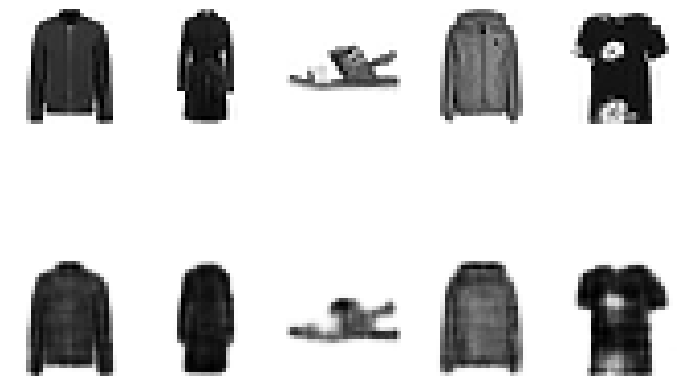

In [22]:
show_reconstructions(conv_ae)

In [23]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

### RNN Autoencoder

In [24]:
rnn_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28,28]),
    keras.layers.LSTM(30)
])
rnn_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

In [25]:
rnn_ae = keras.models.Sequential([rnn_encoder, rnn_decoder])


### Denoising Autoencoder

In [26]:
denoise_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
denoise_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'), 
    keras.layers.Reshape([28,28])
])

In [27]:
denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])
denoise_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = denoise_ae.fit(X_train, X_train, epochs=10, validation_data=(X_val, X_val))

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3604 - rounded_accuracy: 0.8677 - val_loss: 0.3190 - val_rounded_accuracy: 0.9037
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3199 - rounded_accuracy: 0.9019 - val_loss: 0.3118 - val_rounded_accuracy: 0.9078
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3139 - rounded_accuracy: 0.9064 - val_loss: 0.3064 - val_rounded_accuracy: 0.9140
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3102 - rounded_accuracy: 0.9096 - val_loss: 0.3041 - val_rounded_accuracy: 0.9144
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3074 - rounded_accuracy: 0.9118 - val_loss: 0.3007 - val_rounded_accuracy: 0.9196
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3054 - rounded_accuracy: 0.9135 - val_loss: 0.2989 - val_rounded_accuracy: 0.9206
Epoch 7/10
1500/1500 [==================

In [28]:
show_reconstructions(denoise_ae)

(-0.5, 27.5, 27.5, -0.5)

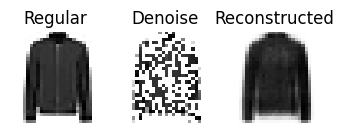

In [29]:
dropout = keras.layers.Dropout(0.5)
figure = plt.figure(figsize=[4,3])
figure.add_subplot(1,3,1)
plt.imshow(X_val[0], cmap='binary')
plt.title('Regular')
plt.axis('off')
figure.add_subplot(1,3,2)
plt.imshow(dropout(X_val[0], training=True), cmap='binary')
plt.title('Denoise')
plt.axis('off')
figure.add_subplot(1,3,3)
plt.imshow(denoise_ae(dropout(X_val))[0], cmap='binary')
plt.title('Reconstructed')
plt.axis('off')

### Sparse Autoencoder

In [30]:
sparse_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=keras.regularizers.l1(1e-3))
])

sparse_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

In [31]:
sparse_ae = keras.models.Sequential([sparse_encoder, sparse_decoder])
sparse_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = sparse_ae.fit(X_train, X_train, epochs=20, validation_data=(X_val, X_val))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4376 - rounded_accuracy: 0.8084 - val_loss: 0.3823 - val_rounded_accuracy: 0.8584
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3726 - rounded_accuracy: 0.8654 - val_loss: 0.3647 - val_rounded_accuracy: 0.8720
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3585 - rounded_accuracy: 0.8772 - val_loss: 0.3525 - val_rounded_accuracy: 0.8803
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3474 - rounded_accuracy: 0.8855 - val_loss: 0.3439 - val_rounded_accuracy: 0.8904
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3401 - rounded_accuracy: 0.8906 - val_loss: 0.3368 - val_rounded_accuracy: 0.8932
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3338 - rounded_accuracy: 0.8962 - val_loss: 0.3318 - val_rounded_accuracy: 0.8953
Epoch 7/20
1500/1500 [==================

### Variational Autoencoders

In [32]:
import keras.backend as K

In [33]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_sigma = inputs
        epsilon = keras.backend.random_normal(tf.shape(z_sigma))
        return z_mean + tf.math.exp(z_sigma / 2) * epsilon

In [34]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])


# KL_divergence=−0.5×∑i=1N​(1+log(σi2​)−μi2​−σi2​)
# Because we interpret the output as the logarithm of the variance.
# in the kl_div below we exponent the log of variance to get clean variance
kl_divergence = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)
variational_ae.add_loss(keras.backend.mean(kl_divergence) / 784.)
variational_ae.compile(loss="mse", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_val, X_val))


Epoch 1/25
375/375 [==============================] - 3s 8ms/step - loss: 0.0815 - rounded_accuracy: 0.7856 - val_loss: 0.0595 - val_rounded_accuracy: 0.8516
Epoch 2/25
375/375 [==============================] - 2s 7ms/step - loss: 0.0565 - rounded_accuracy: 0.8525 - val_loss: 0.0543 - val_rounded_accuracy: 0.8556
Epoch 3/25
375/375 [==============================] - 3s 7ms/step - loss: 0.0501 - rounded_accuracy: 0.8701 - val_loss: 0.0475 - val_rounded_accuracy: 0.8833
Epoch 4/25
375/375 [==============================] - 3s 7ms/step - loss: 0.0451 - rounded_accuracy: 0.8816 - val_loss: 0.0430 - val_rounded_accuracy: 0.8857
Epoch 5/25
375/375 [==============================] - 3s 7ms/step - loss: 0.0429 - rounded_accuracy: 0.8865 - val_loss: 0.0416 - val_rounded_accuracy: 0.8920
Epoch 6/25
375/375 [==============================] - 2s 7ms/step - loss: 0.0415 - rounded_accuracy: 0.8894 - val_loss: 0.0406 - val_rounded_accuracy: 0.8918
Epoch 7/25
375/375 [==============================] 

In [35]:
print(variational_encoder.summary())
print(variational_decoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten_4 (Flatten)         (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 dense_17 (Dense)            (None, 150)                  117750    ['flatten_4[0][0]']           
                                                                                                  
 dense_18 (Dense)            (None, 100)                  15100     ['dense_17[0][0]']            
                                                                                              

In [36]:
codings = tf.random.normal(shape=[12, 10])
print(codings)

tf.Tensor(
[[-1.4859111  -0.41375098 -0.12090848 -0.938697    1.252411    1.5219064
   0.48904943 -0.53001523 -0.0592353   1.7797498 ]
 [-0.26782984  2.3586085   0.04190388  0.09654208  0.44482094  0.07717243
   0.16861868 -0.6093685  -1.9585083   0.31704593]
 [ 2.2665079  -1.5769843   0.6868216  -0.35091737 -0.49148586 -0.31407306
   0.07486669  0.77900815 -0.13695924  1.0028445 ]
 [-0.5904533   0.12492382  1.3298353  -1.7878554   0.3279661   1.3452884
  -0.12984642  0.2348685  -1.1690192   1.649084  ]
 [-0.4675805   0.43409532  0.64415    -1.5397556  -0.9228452  -0.08855826
  -0.4864456   0.6946597  -0.441037    0.5023273 ]
 [-0.836195    0.99188006 -0.07734346  0.89333826 -0.86002105 -1.0085505
  -0.78078634  0.00525745  1.4615624  -0.22867496]
 [-0.25251132 -1.3368063   0.33125708 -0.42125925  1.3770177   0.8944764
  -0.29974747  2.2455647   0.6541947  -0.8862695 ]
 [-0.39697522  2.5920837   0.07109897 -0.17584954 -1.4259827   0.2788739
  -0.8983691   0.61568385  1.7723767  -0.4149

In [37]:
reconstructions = variational_decoder(codings).numpy()
def plot_multiple_images(images, n_columns=None):
    n_images = images.shape[0]
    n_columns = n_columns or len(images)
    n_rows =  n_images // n_columns + 1
    figure = plt.figure(figsize=[4,3])
    for i, image in enumerate(images):
        figure.add_subplot(n_rows, n_columns, i + 1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

In [38]:
# plot_multiple_images(reconstructions, n_columns=4)

### Generative Adversarial Networks (GANS)

In [39]:
keras.backend.clear_session()

In [40]:
codings_dim = 20

generator = keras.models.Sequential([
    keras.layers.Input(shape=[codings_dim]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [41]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [42]:
def train_gan(gan, dataset, batch_size, codings_dim, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for batch in dataset:
            # Phase 1 -> training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_dim])
            fake_images = generator(noise)
            X = tf.concat([batch, fake_images], axis=0)
            Y = tf.constant([[1]] * batch_size + [[0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X, Y)
            # Phase 2 -> training the generator
            noise = tf.random.normal(shape=[batch_size, codings_dim])
            y = tf.constant([[1]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y)
        plot_multiple_images(fake_images, 8)
        plt.show()

In [43]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(48000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

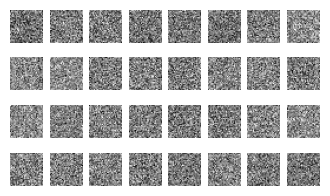

In [44]:
# Before training
noise = tf.random.normal(shape=[batch_size, 20])
plot_multiple_images(generator(noise), 8)

Epoch 1/1


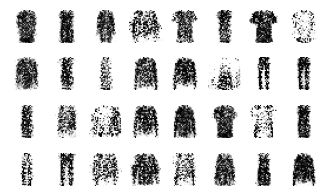

In [45]:
# 1 Training epoch
train_gan(gan, dataset, 32, 20, 1)

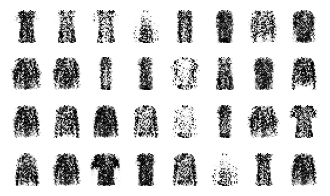

In [46]:
# After training for 1 epoch
noise = tf.random.normal(shape=[batch_size, 20])
plot_multiple_images(generator(noise), 8)

Epoch 1/50


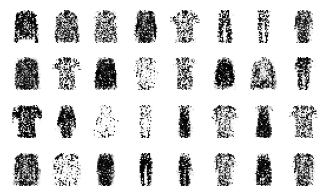

Epoch 2/50


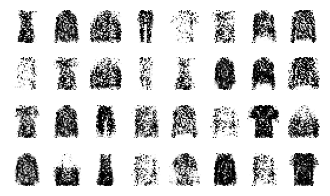

Epoch 3/50


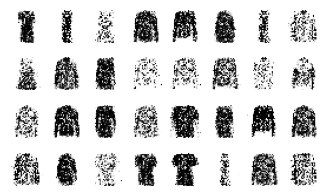

Epoch 4/50


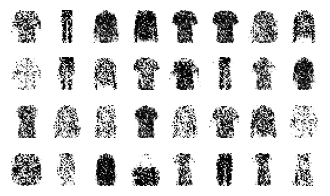

Epoch 5/50


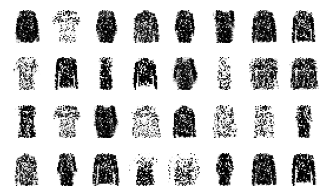

Epoch 6/50


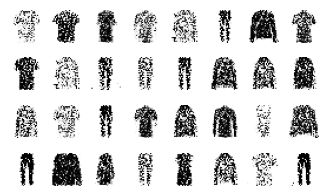

Epoch 7/50


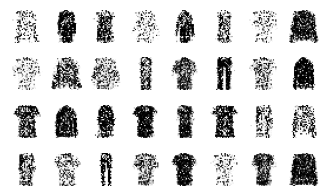

Epoch 8/50


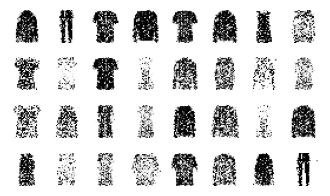

Epoch 9/50


Epoch 10/50


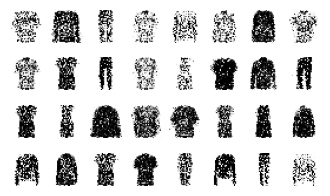

Epoch 11/50


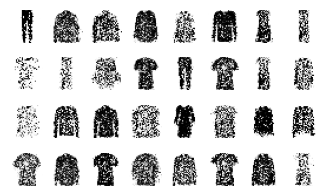

Epoch 12/50


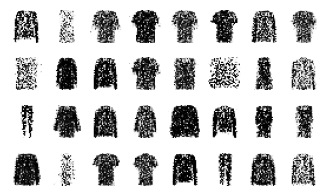

Epoch 13/50


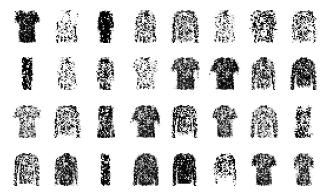

Epoch 14/50


Epoch 15/50


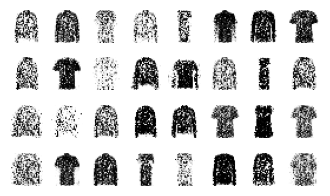

Epoch 16/50


Epoch 17/50


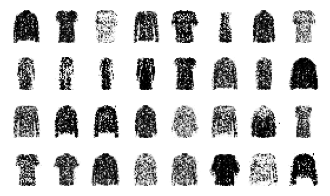

Epoch 18/50


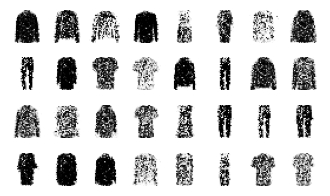

Epoch 19/50


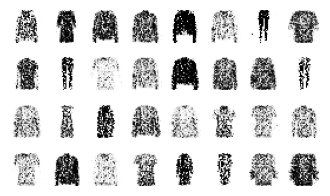

Epoch 20/50


Epoch 21/50


Epoch 22/50


Epoch 23/50


Epoch 24/50


Epoch 25/50


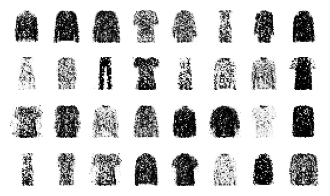

Epoch 26/50


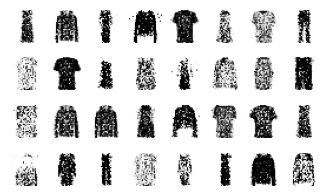

Epoch 27/50


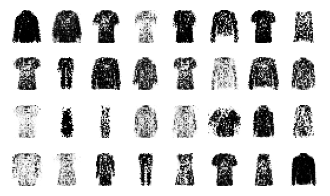

Epoch 28/50


Epoch 29/50


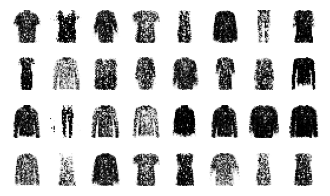

Epoch 30/50


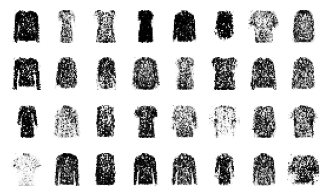

Epoch 31/50


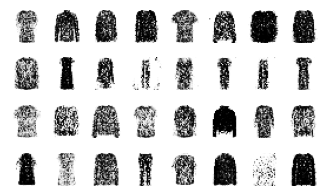

Epoch 32/50


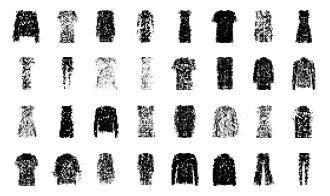

Epoch 33/50


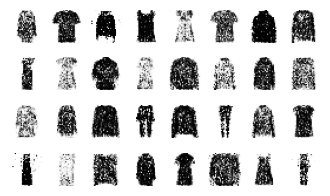

Epoch 34/50


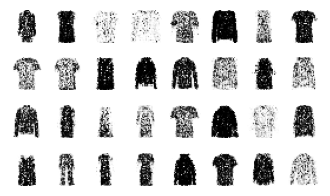

Epoch 35/50


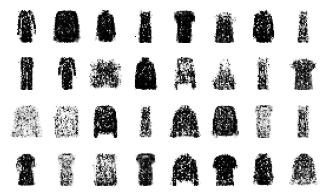

Epoch 36/50


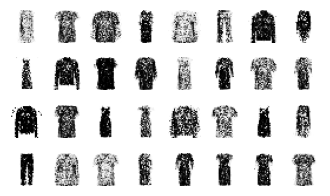

Epoch 37/50


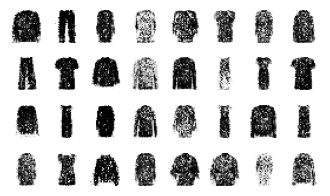

Epoch 38/50


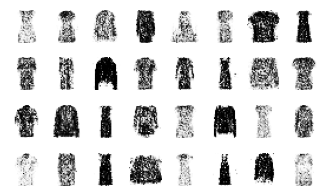

Epoch 39/50


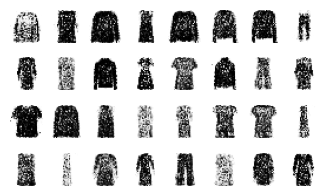

Epoch 40/50


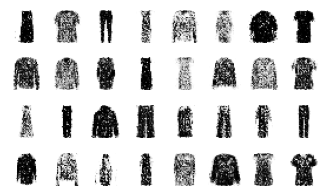

Epoch 41/50


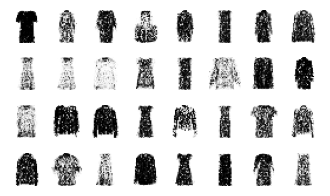

Epoch 42/50


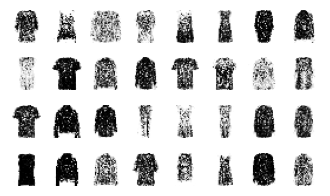

Epoch 43/50


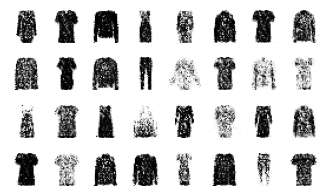

Epoch 44/50


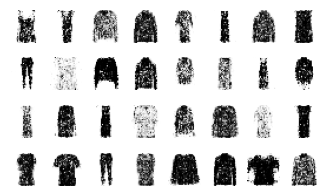

Epoch 45/50


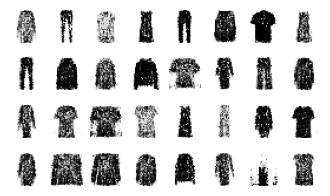

Epoch 46/50


Epoch 47/50


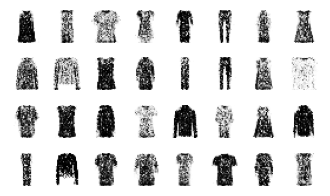

Epoch 48/50


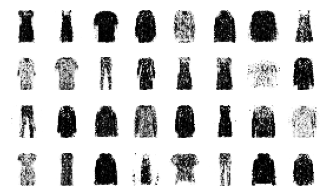

Epoch 49/50


Epoch 50/50


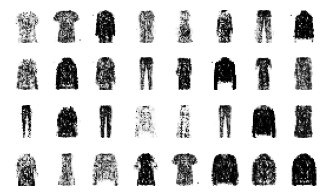

In [47]:
train_gan(gan, dataset, 32, 20, 50)

In [48]:
exmp = np.array([[[[1.],[2.],[3.]],[[1.],[2.],[3.]],[[1.],[2.],[3.]]]])

In [49]:
exmp.shape

(1, 3, 3, 1)

In [50]:
keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2)(exmp)

<tf.Tensor: shape=(1, 7, 7, 3), dtype=float32, numpy=
array([[[[ 0.1629582 , -0.0637483 ,  0.3482467 ],
         [ 0.02115747,  0.40375364,  0.10342163],
         [-0.06500527, -0.09744346,  0.73112315],
         [ 0.04231495,  0.8075073 ,  0.20684326],
         [-0.29296875, -0.13113862,  1.1139996 ],
         [ 0.06347242,  1.2112609 ,  0.3102649 ],
         [-1.172765  ,  0.09015942,  0.10388929]],

        [[-0.21601593, -0.28403497, -0.20464459],
         [ 0.35096115,  0.00827661,  0.19642776],
         [-0.4381343 , -0.5018986 , -0.3219149 ],
         [ 0.7019223 ,  0.01655322,  0.39285553],
         [-0.6602527 , -0.7197622 , -0.43918526],
         [ 1.0528834 ,  0.02482983,  0.5892833 ],
         [-0.01830733,  0.19851404,  0.2621228 ]],

        [[-0.2432675 ,  0.21153265,  0.4304027 ],
         [-0.10940263,  0.7013894 , -0.23216948],
         [-1.2824872 ,  0.4740169 ,  1.2882609 ],
         [-0.21880525,  1.4027787 , -0.46433896],
         [-2.3217068 ,  0.7365012 ,  2.146

### Conv GANS

In [51]:
keras.backend.clear_session()

codings_dim = 100

generator = keras.models.Sequential([
    keras.layers.Input(shape=[codings_dim]),
    keras.layers.Dense(7*7*128),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation='tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Input(shape=[28,28,1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [52]:
gan = keras.models.Sequential([generator, discriminator])

In [53]:
# We want our input to be (batch_size, w, h, ch) and in range of -1 <-> 1 so we reshape our data
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(1)

In [54]:
discriminator.compile(loss="binary_crossentropy", optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Epoch 1/50


Epoch 2/50


Epoch 3/50


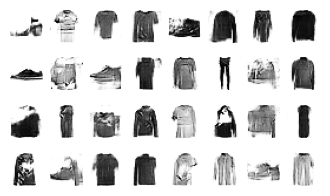

Epoch 4/50


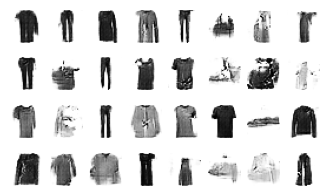

Epoch 5/50


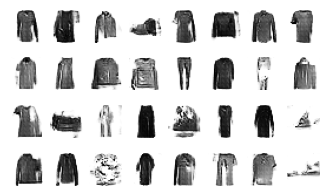

Epoch 6/50


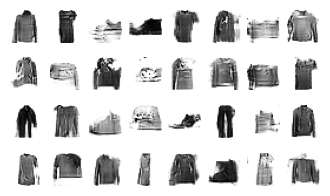

Epoch 7/50


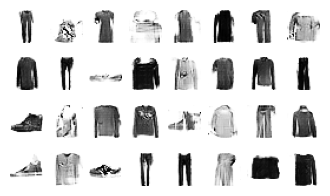

Epoch 8/50


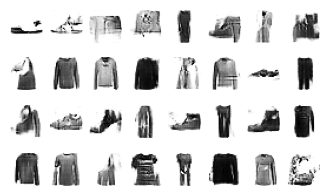

Epoch 9/50


Epoch 10/50


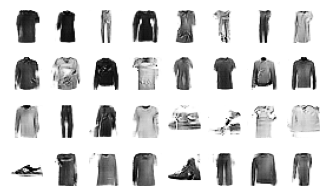

Epoch 11/50


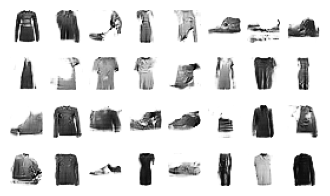

Epoch 12/50


Epoch 13/50


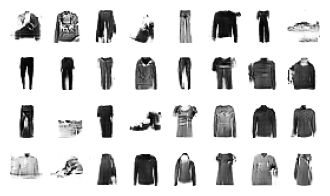

Epoch 14/50


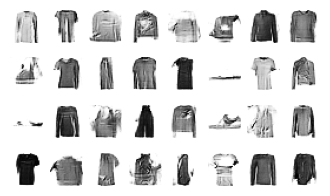

Epoch 15/50


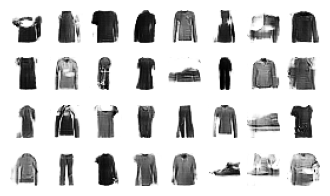

Epoch 16/50


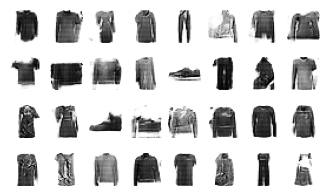

Epoch 17/50


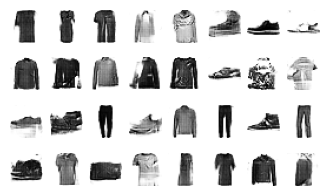

Epoch 18/50


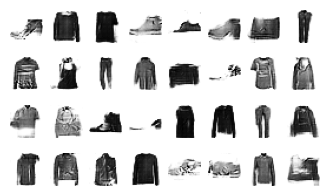

Epoch 19/50


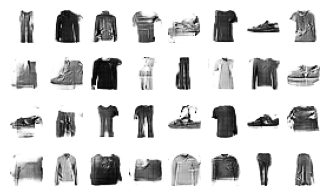

Epoch 20/50


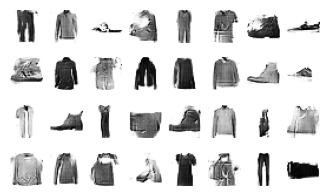

Epoch 21/50


Epoch 22/50


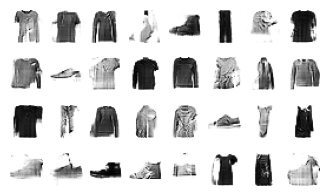

Epoch 23/50


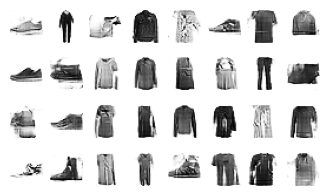

Epoch 24/50


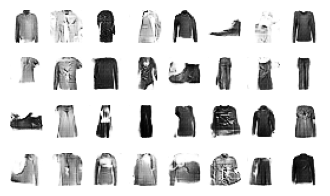

Epoch 25/50


Epoch 26/50


Epoch 27/50


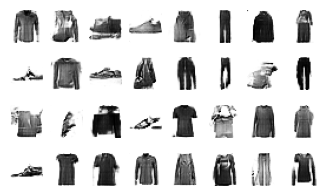

Epoch 28/50


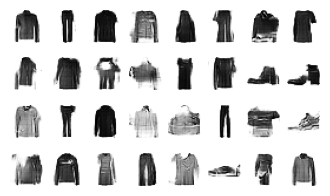

Epoch 29/50


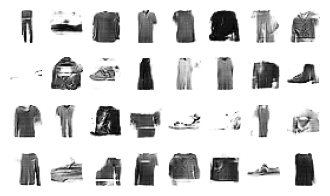

Epoch 30/50


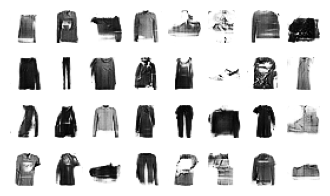

Epoch 31/50


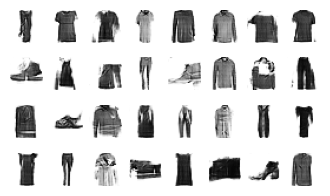

Epoch 32/50


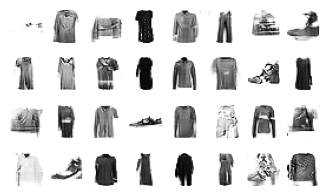

Epoch 33/50


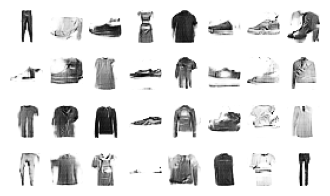

Epoch 34/50


Epoch 35/50


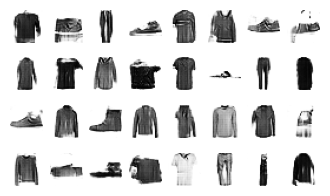

Epoch 36/50


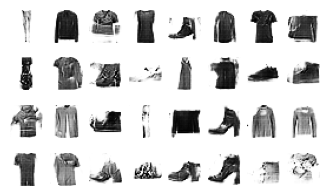

Epoch 37/50


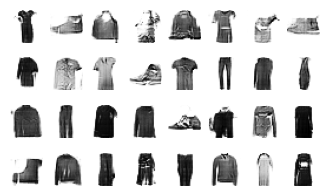

Epoch 38/50


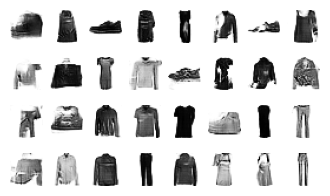

Epoch 39/50


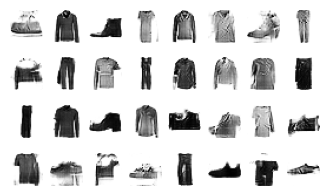

Epoch 40/50


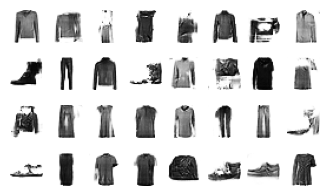

Epoch 41/50


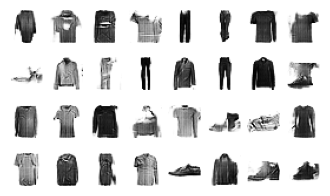

Epoch 42/50


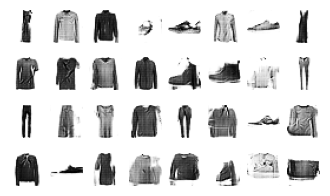

Epoch 43/50


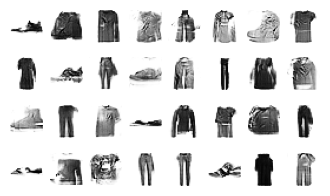

Epoch 44/50


Epoch 45/50


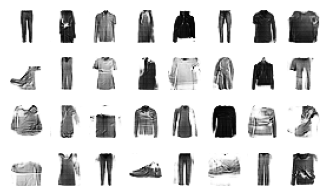

Epoch 46/50


Epoch 47/50


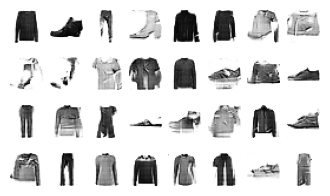

Epoch 48/50


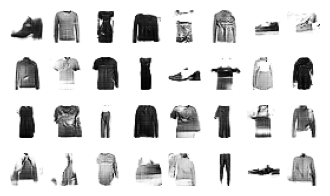

Epoch 49/50


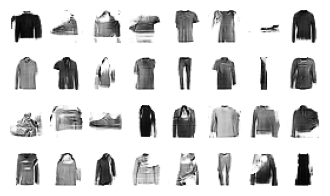

Epoch 50/50


In [55]:
train_gan(gan, dataset, batch_size, codings_dim)